# 2D SSN Model

In this notebook:
- training script for SSN model
- implementation of vmap

Information on training vmap:
- https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html
- https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html

Imports

In [4]:
import matplotlib.pyplot as plt
import time, os, json
import pandas as pd
from scipy import stats 
from tqdm import tqdm
import seaborn as sns
import jax
from jax import random
from jax.config import config 
import jax.numpy as np
from jax import vmap
import pdb
import optax
import time
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


#config.update('jax_debug_nans', True)
from SSN_classes_jax import SSN2DTopoV1_AMPAGABA_ONOFF
from util import GaborFilter, BW_Grating, find_A, create_gabor_filters, create_gratings

## GENERATE DATA

In [5]:
#Gabor parameters 
sigma_g= 0.5
k = np.pi/(6*sigma_g)

#Parameters shared with stimuli
general_pars = dict(k=k , edge_deg=3.2,  degree_per_pixel=0.05)

In [6]:
#Stimuli parameters
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, snr = 1)
stimuli_pars.update(general_pars)

#Create gratings at given or ientation and list of labels
data = create_gratings(ref_ori=55, number=5, offset= 0.5, jitter_val=5, **stimuli_pars)
train, test = train_test_split(data, test_size = 0.2)
len(train), len(test)

#batch params 
batch_size= 20
train_dataloader =DataLoader(train, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test, batch_size=len(test), shuffle=False)
number_batches= int(len(train) / batch_size)
number_batches

0

# MODEL TRAINING

1. Define parameters

In [7]:
#Network parameters
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms
    psi = 0.774
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    

#Grid parameters
class grid_pars():
    gridsize_Nx = 9 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)

# Caleb's params for the full (with local) model:
Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
gE, gI = 0.57328625, 0.26144141

sigEE, sigIE = 0.2, 0.40
sigEI, sigII = .09, .09
conn_pars = dict(
    PERIODIC = False,
    p_local = [.4, 0.7], # [p_local_EE, p_local_IE],
    sigma_oris = 1000) # sigma_oris


make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2 = make_J2x2(*Js0)
s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]])

#Positive reparameterization
signs=np.array([[1, -1], [1, -1]])
logJ_2x2 =np.log(J_2x2*signs)
logs_2x2 = np.log(s_2x2)


#Sigmoid parameters
N_neurons = 25
key = random.PRNGKey(60)
w_sig = random.normal(key, shape = (N_neurons,)) / np.sqrt(N_neurons)
b_sig = 0.0


#Optimization pars
opt_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2, w_sig = w_sig, b_sig=b_sig)


#Parameters exclusive to Gabor filters
filter_pars = dict(sigma_g = sigma_g, conv_factor = grid_pars.magnif_factor)
filter_pars.update(general_pars) 

#Convergence parameters
conv_pars=dict(dt = 1, xtol = 1e-5, Tmax = 200, verbose=False, silent=True)

3. TRAINING!

In [8]:
def sigmoid(x):
    return 1/(1+np.exp(x))

def binary_loss(n, x):
    return - (n*np.log(x) + (1-n)*np.log(1-x))

def model(opt_pars, ssn_pars, grid_pars, conn_pars, data, filter_pars,  conv_pars):
    
    signs=np.array([[1, -1], [1, -1]])
    
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])
    
    total_loss=0
    
    for i in range(len(data['ref'])):
        #Initialise network
        ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)
                                                   
        #Apply Gabor filters to stimuli
        output_ref=np.matmul(ssn.gabor_filters, data['ref'][i])*ssn.A
        output_target=np.matmul(ssn.gabor_filters, data['target'][i])*ssn.A

        #Rectify output
        SSN_input_ref=np.maximum(0, output_ref)
        SSN_input_target=np.maximum(0, output_target)
        
        #Input to SSN
        r_init = np.zeros(SSN_input_ref.shape[0])
        
        fp_ref, _ = ssn.fixed_point_r(SSN_input_ref, r_init=r_init, **conv_pars)
        x_ref = ssn.apply_bounding_box(fp_ref, size=3.2)

        fp_target, _ = ssn.fixed_point_r(SSN_input_target, r_init=r_init, **conv_pars)
        x_target = ssn.apply_bounding_box(fp_target, size=3.2)

        #Apply sigmoid function - combine ref and target
        x = sigmoid( np.dot(opt_pars['w_sig'], (x_ref.ravel() - x_target.ravel())) + opt_pars['b_sig'])

        #Calculate binary cross entropy loss
        total_loss+=np.sum(binary_loss(data['label'][i], x))
        
   
    return total_loss
    

def train_SSN(opt_pars, ssn_pars, grid_pars, conn_pars, train_dataloader, test_dataloader, filter_pars, conv_pars, batches, epochs=1, eta=10e-4):
    
    #Initialize loss
    val_loss_per_epoch = []
    
    #Initialise optimizer
    optimizer = optax.adam(eta)
    opt_state = optimizer.init(opt_pars)
    
    #Define test data - no need to iterate
    test_iterator = iter(test_dataloader)
    test_data = next(test_iterator)
    test_data['ref'] = test_data['ref'].numpy()
    test_data['target'] = test_data['target'].numpy()
    test_data['label'] = test_data['label'].numpy()
    
    for epoch in range(epochs):
        
        #Loss and accuracy before training
        if epoch == 0:
            val_loss= model(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars )
            print('Before training  -- loss: {} '.format(val_loss))
            val_loss_per_epoch.append(val_loss)

        
        start_time = time.time()
        train_iterator = iter(train_dataloader)
        test_iterator = iter(test_dataloader)
        
        for batch in range(batches):
            train_data = next(train_iterator)

            train_data['ref'] = train_data['ref'].numpy()
            train_data['target'] = train_data['target'].numpy()
            train_data['label'] = train_data['label'].numpy()

            #compute loss and gradient 
            grad =jax.grad(model)(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars)

            #Apply SGD through Adam optimizer
            updates, opt_state = optimizer.update(grad, opt_state)
            opt_pars = optax.apply_updates(opt_pars, updates)
        
        epoch_time =time.time() - start_time
    
        #Evaluate model
        val_loss = model(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars )
        print('Validation -- loss: {}, at epoch {}, (time {})'.format(val_loss, epoch+1, epoch_time))
        val_loss_per_epoch.append(val_loss)
    
    
    #reparametize parameters
    signs=np.array([[1, -1], [1, -1]])    
    opt_pars['logJ_2x2'] = np.exp(opt_pars['logJ_2x2'])*signs
    opt_pars['logs_2x2'] = np.exp(opt_pars['logs_2x2'])
    opt_pars['J_2x2'] = opt_pars['logJ_2x2']
    opt_pars['s_2x2'] = opt_pars['logs_2x2']
    del opt_pars['logJ_2x2'], opt_pars['logs_2x2']
    
    return opt_pars, val_loss_per_epoch

In [9]:
#model_test = model(opt_pars, ssn_pars, grid_pars, conn_pars, gratings, labels, filter_pars,  **conv_pars)
new_pars, offset_5_loss= train_SSN(opt_pars, ssn_pars, grid_pars, conn_pars, train_dataloader, test_dataloader, filter_pars, conv_pars, batches = number_batches, epochs=20)

Before training  -- loss: 0.6629167795181274 
Validation -- loss: 0.6629167795181274, at epoch 1, (time 0.00029540061950683594)
Validation -- loss: 0.6629167795181274, at epoch 2, (time 0.00027823448181152344)
Validation -- loss: 0.6629167795181274, at epoch 3, (time 0.0003490447998046875)
Validation -- loss: 0.6629167795181274, at epoch 4, (time 0.00025916099548339844)
Validation -- loss: 0.6629167795181274, at epoch 5, (time 0.00027823448181152344)
Validation -- loss: 0.6629167795181274, at epoch 6, (time 0.0002734661102294922)



KeyboardInterrupt



# Vmap implementation

In [26]:
def sigmoid(x):
    return 1/(1+np.exp(x))

def binary_loss(n, x):
    return - (n*np.log(x) + (1-n)*np.log(1-x))

def model(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars):
    
    signs=np.array([[1, -1], [1, -1]])
    
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])
    
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)

    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, train_data['ref'])*ssn.A
    output_target=np.matmul(ssn.gabor_filters, train_data['target'])*ssn.A

    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Input to SSN
    r_init = np.zeros(SSN_input_ref.shape[0])

    fp_ref, _ = ssn.fixed_point_r(SSN_input_ref, r_init=r_init, **conv_pars)
    x_ref = ssn.apply_bounding_box(fp_ref, size=3.2)

    fp_target, _ = ssn.fixed_point_r(SSN_input_target, r_init=r_init, **conv_pars)
    x_target = ssn.apply_bounding_box(fp_target, size=3.2)

    #Apply sigmoid function - combine ref and target
    x = sigmoid( np.dot(opt_pars['w_sig'], (x_ref.ravel() - x_target.ravel())) + opt_pars['b_sig'])

    #Calculate binary cross entropy loss
    loss=binary_loss(train_data['label'], x)
   
    return loss


def loss(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars):
    '''
    Calculate parallelized loss for batch of data through vmap.
    Output:
        mean loss of all the input images
    '''
    
    vmap_model = vmap(model, in_axes = ({'b_sig': None, 'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )                   
    loss = np.sum(vmap_model(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars))

    return loss


def train_SSN_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, train_dataloader, test_dataloader, filter_pars, conv_pars, batches, epochs=1, eta=10e-4):
    
    #Initialize loss
    val_loss_per_epoch = []
    training_losses=[]
    accuracies=[]
    
    #Initialise optimizer
    optimizer = optax.adam(eta)
    opt_state = optimizer.init(opt_pars)
    
    #Define test data - no need to iterate
    test_iterator = iter(test_dataloader)
    test_data = next(test_iterator)
    test_data['ref'] = test_data['ref'].numpy()
    test_data['target'] = test_data['target'].numpy()
    test_data['label'] = test_data['label'].numpy()
    
    val_loss, accuracy= vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)

    print('Before training  -- loss: {}, accuracy: {} '.format(val_loss, accuracy))
    val_loss_per_epoch.append(val_loss)
    accuracies.append(accuracy)

    
    for epoch in range(epochs):
        start_time = time.time()
        train_iterator = iter(train_dataloader)
        epoch_loss = 0 
           
        #Iterate through data in batches
        for batch in range(batches): 

            #load next batch of data and convert
            train_data = next(train_iterator)
            #convert tensors to numpy
            train_data['ref'] = train_data['ref'].numpy()
            train_data['target'] = train_data['target'].numpy()
            train_data['label'] = train_data['label'].numpy()
            
            #Compute loss and gradient
            batch_loss, grad =jax.value_and_grad(loss)(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars)
            
            #Apply SGD through Adam optimizer per batch
            updates, opt_state = optimizer.update(grad, opt_state)
            opt_pars = optax.apply_updates(opt_pars, updates)
            epoch_loss+=batch_loss
        
        epoch_time = time.time() - start_time
        
        
        #Evaluate model at the end of each epoch
        val_loss, accuracy= vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
        print('Training loss: {} ¦ Validation -- loss: {}, accuracy: {} at epoch {}, (time {})'.format(epoch_loss, val_loss, accuracy, epoch+1, epoch_time))
        val_loss_per_epoch.append(val_loss)
        training_losses.append(epoch_loss)
        accuracies.append(accuracy)
    
    #reparametize parameters
    signs=np.array([[1, -1], [1, -1]])    
    opt_pars['logJ_2x2'] = np.exp(opt_pars['logJ_2x2'])*signs
    opt_pars['logs_2x2'] = np.exp(opt_pars['logs_2x2'])
    
    return opt_pars, val_loss_per_epoch, accuracies


def eval_model(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars):
    signs=np.array([[1, -1], [1, -1]])
    
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])
    
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)

    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, test_data['ref'])*ssn.A
    output_target=np.matmul(ssn.gabor_filters, test_data['target'])*ssn.A

    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Input to SSN
    r_init = np.zeros(SSN_input_ref.shape[0])

    fp_ref, _ = ssn.fixed_point_r(SSN_input_ref, r_init=r_init, **conv_pars)
    x_ref = ssn.apply_bounding_box(fp_ref, size=3.2)

    fp_target, _ = ssn.fixed_point_r(SSN_input_target, r_init=r_init, **conv_pars)
    x_target = ssn.apply_bounding_box(fp_target, size=3.2)

    #Apply sigmoid function - combine ref and target
    x = sigmoid( np.dot(opt_pars['w_sig'], (x_ref.ravel() - x_target.ravel())) + opt_pars['b_sig'])
    
    #compare prediction to label
    pred_label = np.round(x)

    #Calculate binary cross entropy loss
    loss=binary_loss(test_data['label'], x)
    
    return loss, pred_label, x

def vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars):
    
    eval_vmap = vmap(eval_model, in_axes = ({'b_sig': None, 'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )
    losses, pred_labels, _ = eval_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
    
    accuracy = np.sum(test_data['label'] == pred_labels)/len(test_data['label']) 
    
    vmap_loss= np.mean(losses)
    
    return vmap_loss, accuracy

In [14]:
#OFFSET - 5, eta = 10e-4
vmap_pars, vmap_val_loss, acc = train_SSN_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, train_dataloader, test_dataloader, filter_pars,  conv_pars, batches = number_batches, epochs = 20)

In [59]:
#OFFSET - 05, eta = 10e-4
vmap_pars_05, vmap_val_loss_05, acc_05 = train_SSN_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, train_dataloader, test_dataloader, filter_pars,  conv_pars, batches = number_batches, epochs = 20)

Before training  -- loss: 0.7708415985107422, accuracy: 0.3400000035762787 
Training loss: 155.9490966796875 ¦ Validation -- loss: 0.7486924529075623, accuracy: 0.3400000035762787 at epoch 1, (time 53.977357149124146)
Training loss: 152.0327911376953 ¦ Validation -- loss: 0.7348071336746216, accuracy: 0.36000001430511475 at epoch 2, (time 53.79437446594238)
Training loss: 149.38291931152344 ¦ Validation -- loss: 0.7255972623825073, accuracy: 0.3799999952316284 at epoch 3, (time 54.45169234275818)
Training loss: 147.525146484375 ¦ Validation -- loss: 0.7191407680511475, accuracy: 0.4399999976158142 at epoch 4, (time 53.74654006958008)
Training loss: 146.1613006591797 ¦ Validation -- loss: 0.7143919467926025, accuracy: 0.4399999976158142 at epoch 5, (time 54.12783145904541)
Training loss: 145.11245727539062 ¦ Validation -- loss: 0.7107369899749756, accuracy: 0.4399999976158142 at epoch 6, (time 53.79789471626282)
Training loss: 144.2670440673828 ¦ Validation -- loss: 0.7077839374542236, 

## TESTS

### 1. Testing accuracies of different initializations

In [ ]:
#TESTING INTIALISATION 
accuracies=[]

for i in range(100):
    #Sigmoid parameters
    N_neurons = 25
    #key = random.PRNGKey(7)
    key, _ = random.split(key)
    w_sig = random.normal(key, shape = (N_neurons,)) / np.sqrt(N_neurons)
    b_sig = 0.0

    print(w_sig[0])

    #Optimization pars
    opt_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2, w_sig = w_sig, b_sig=b_sig)

    #Parameters exclusive to Gabor filters
    filter_pars = dict(sigma_g = sigma_g, conv_factor = grid_pars.magnif_factor)
    filter_pars.update(general_pars) 

    #Convergence parameters
    conv_pars=dict(dt = 1, xtol = 1e-5, Tmax = 200, verbose=False, silent=True)


    test_iterator = iter(test_dataloader)
    test_data = next(test_iterator)
    test_data['ref'] = test_data['ref'].numpy()
    test_data['target'] = test_data['target'].numpy()
    test_data['label'] = test_data['label'].numpy()

    val_loss, accuracy= vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
    accuracies.append(accuracy)

    #print('Before training  -- loss: {}, accuracy: {} '.format(val_loss, accuracy))

print('mean accuracy {}'.format(np.mean(np.array(accuracies))))
print('std accuracy {}'.format(np.std(np.array(accuracies))))

contrast = 0.5, mean accuracy 0.5307999849319458 (mean accuracy 0.5013999938964844)
std accuracy 0.1768936514854431 (std accuracy 0.18155451118946075)

contrast = 0.8
mean accuracy 0.5005999803543091
std accuracy0.1579735428094864

contrast = 0.99 mean accuracy 0.4772000014781952
std accuracy 0.14111045002937317

### 2. Testing noise levels

In [120]:
def evaluate_noise(opt_pars, ssn_pars, grid_pars,  conn_pars, train_data, filter_pars,  conv_pars):

    signs=np.array([[1, -1], [1, -1]])
    
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])
    
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)

    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, train_data['ref'])*ssn.A
    output_target=np.matmul(ssn.gabor_filters, train_data['target'])*ssn.A

    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target) # - baseline input

    #Input to SSN
    r_init = np.zeros(SSN_input_ref.shape[0])

    fp_ref, _ = ssn.fixed_point_r(SSN_input_ref, r_init=r_init, **conv_pars)
    x_ref = ssn.apply_bounding_box(fp_ref, size=3.2)

    fp_target, _ = ssn.fixed_point_r(SSN_input_target, r_init=r_init, **conv_pars)
    x_target = ssn.apply_bounding_box(fp_target, size=3.2)

    return np.linalg.norm(x_ref - x_target), SSN_input_ref

def vmap_evaluate_noise(stimuli_pars, opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, offset=1):
        
    #Create gratings at given or ientation and list of labels
    train_data = create_gratings(ref_ori=55, number=100, offset= offset, jitter_val=5, **stimuli_pars)
    train_data = next(iter(DataLoader(train_data, batch_size=len(train_data), shuffle=False)))
    train_data['ref'] = train_data['ref'].numpy()
    train_data['target'] = train_data['target'].numpy()
    train_data['label'] = train_data['label'].numpy()
    
    plt.imshow(train_data['ref'][0].reshape(129, 129))
    

    vmap_eval_noise = vmap(evaluate_noise, in_axes = ({'b_sig': None, 'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )
    x_vectors, SSN_inputs = vmap_eval_noise(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars)
    
    mean = np.mean(x_vectors)
    std = np.std(x_vectors)
    
    output_snr = mean/std
    
    return mean, std, output_snr

(DeviceArray(1.4078033, dtype=float32),
 DeviceArray(0.90460044, dtype=float32),
 DeviceArray(1.5562708, dtype=float32))

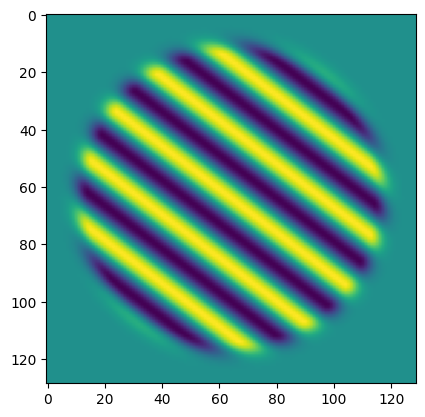

In [123]:
#Stimuli parameters
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, snr = 1)
stimuli_pars.update(general_pars)

vmap_evaluate_noise(stimuli_pars, opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars)

(DeviceArray(2.005949, dtype=float32),
 DeviceArray(0.7657847, dtype=float32),
 DeviceArray(2.6194687, dtype=float32))

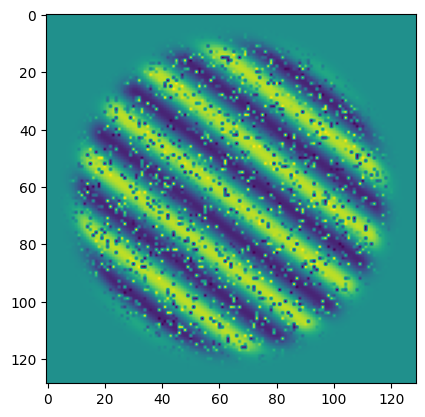

In [8]:
#Stimuli parameters
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, snr = 0.8)
stimuli_pars.update(general_pars)

vmap_evaluate_noise(stimuli_pars, opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars)

(DeviceArray(2.9141607, dtype=float32),
 DeviceArray(0.95722467, dtype=float32),
 DeviceArray(3.0443854, dtype=float32))

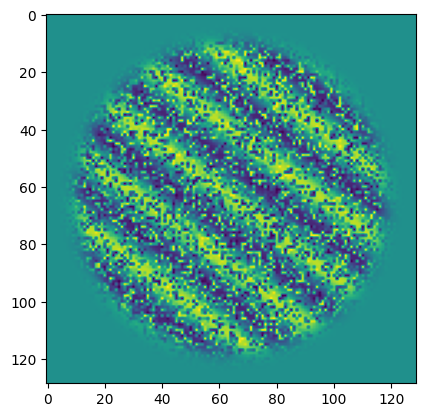

In [9]:
#Stimuli parameters
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, snr = 0.5)
stimuli_pars.update(general_pars)

vmap_evaluate_noise(stimuli_pars, opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars)

(DeviceArray(6.380408, dtype=float32),
 DeviceArray(1.8128526, dtype=float32),
 DeviceArray(3.5195403, dtype=float32))

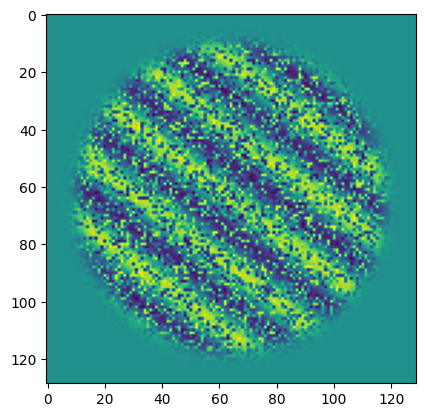

In [10]:
#Stimuli parameters
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, snr = 0.5)
stimuli_pars.update(general_pars)

vmap_evaluate_noise(stimuli_pars, opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, offset = 5)

(DeviceArray(8.799837, dtype=float32),
 DeviceArray(2.6397405, dtype=float32),
 DeviceArray(3.3335993, dtype=float32))

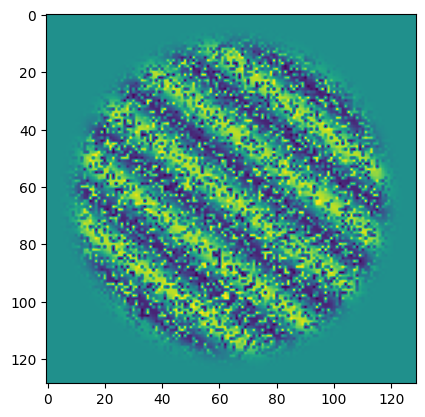

In [11]:
#Stimuli parameters
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, snr = 0.5)
stimuli_pars.update(general_pars)

vmap_evaluate_noise(stimuli_pars, opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, offset = 10)

In [50]:
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.99, snr =1)
stimuli_pars.update(general_pars)
train_data = create_gratings(ref_ori=55, number=1, offset= 1, jitter_val=5, **stimuli_pars)
train_data = train_data[0]
#train_data = next(iter(DataLoader(train_data, batch_size=len(train_data), shuffle=False)))

## Histograms

In [109]:
def vmap_sigmoid(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars):
    
    eval_vmap = vmap(eval_model, in_axes = ({'b_sig': None, 'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )
    _, _, sigmoid_output = eval_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
    
    return sigmoid_output

def histograms(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, jitter_val, snr, trials = 9):
    
    #intitialise empty trials list
    all_trials=[]
    all_w_sigs = []
    
    #Stimuli parameters
    stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, snr = snr)
    stimuli_pars.update(general_pars)
    key = random.PRNGKey(60)
    
    for i in range (trials):
        
        key, _ = random.split(key)
        opt_pars['w_sig'] = random.normal(key, shape = (N_neurons,)) / np.sqrt(N_neurons)
        all_w_sigs.append(opt_pars['w_sig'])

        #Create gratings at given or ientation and list of labels
        data = create_gratings(ref_ori=55, number=200, offset= 5, jitter_val=jitter_val, **stimuli_pars)
        train_data = next(iter(DataLoader(data, batch_size=len(data), shuffle=False)))
        train_data['ref'] = train_data['ref'].numpy()
        train_data['target'] = train_data['target'].numpy()
        train_data['label'] = train_data['label'].numpy()


        sigmoid_output =vmap_sigmoid(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars)
        
        
        all_trials.append(sigmoid_output)
        
    
    #create plots
    n_rows =  int(np.sqrt(trials))
    n_cols = int(np.ceil(trials / n_rows))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,15))
    fig.suptitle('SNR: '+str(snr)+', jitter: '+str(jitter_val))

    count = 0
    
    
   #plot histograms
    for k in range(n_rows):
        for j in range (n_cols):
            axs[k,j].hist(all_trials[count])
            axs[k,j].set_xlabel('Sigmoid output')
            axs[k,j].set_ylabel('Frequency')
            count+=1
    
    return all_trials, all_w_sigs



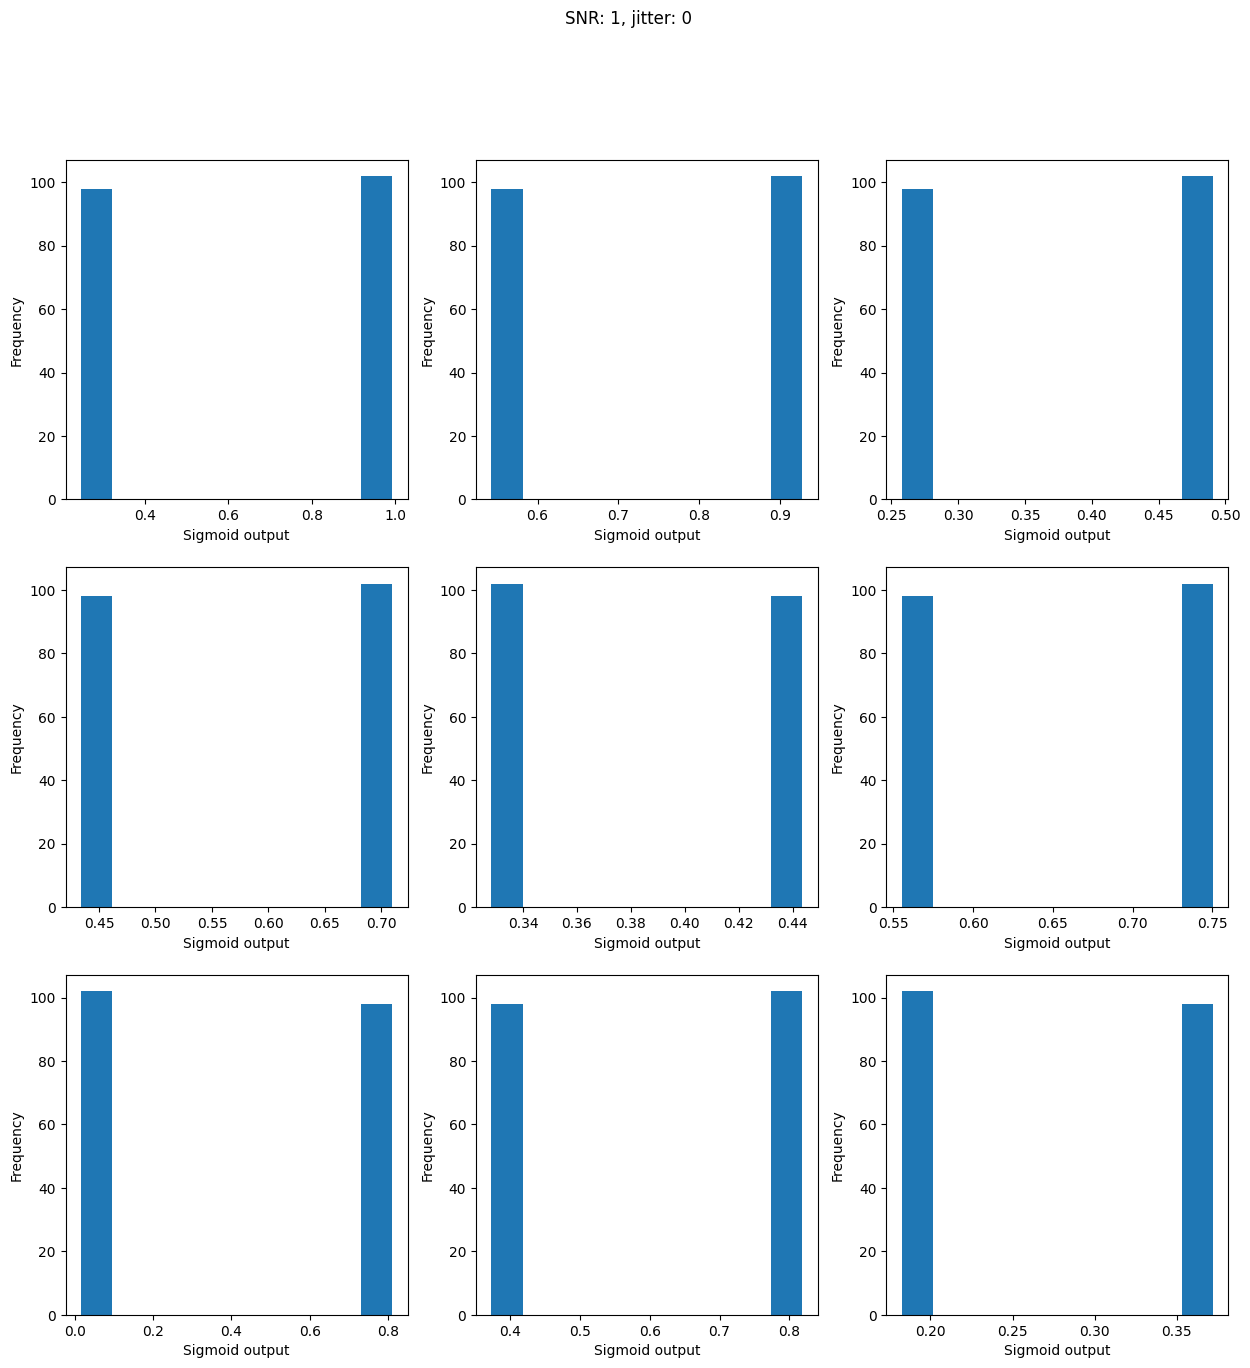

In [110]:
sig_trials, w_sigs = histograms(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, jitter_val = 0, snr = 1, trials = 9)

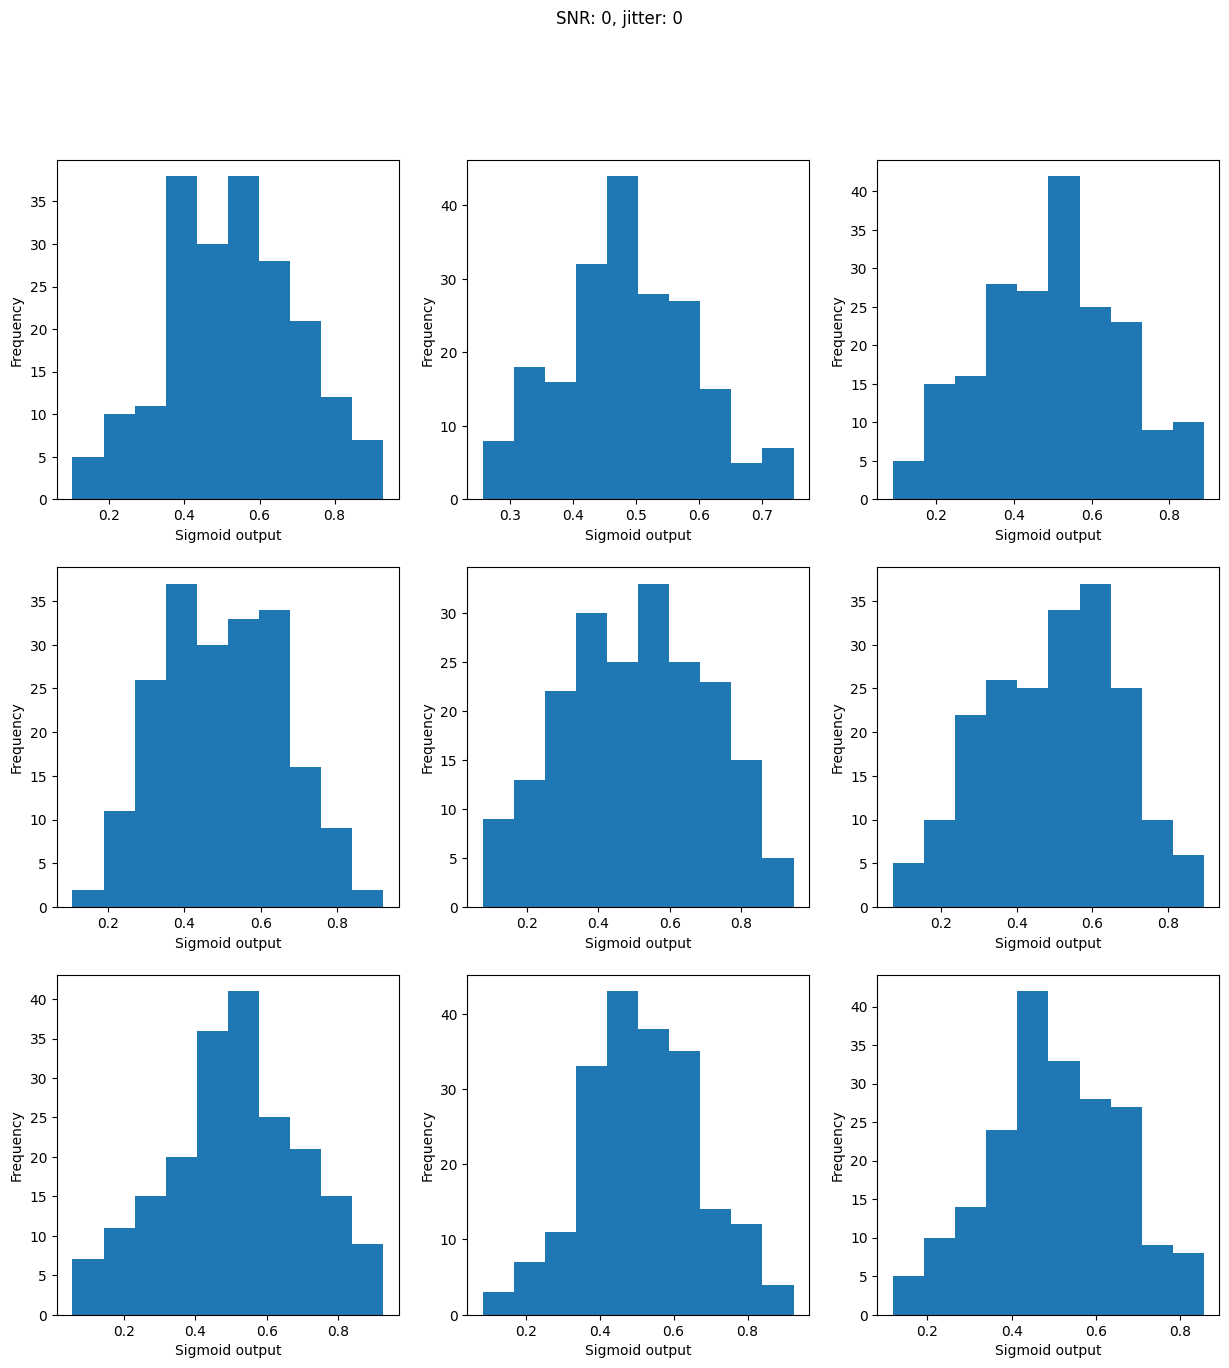

In [112]:
sig_trials_, _ = histograms(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, jitter_val = 0, snr = 0, trials = 9)

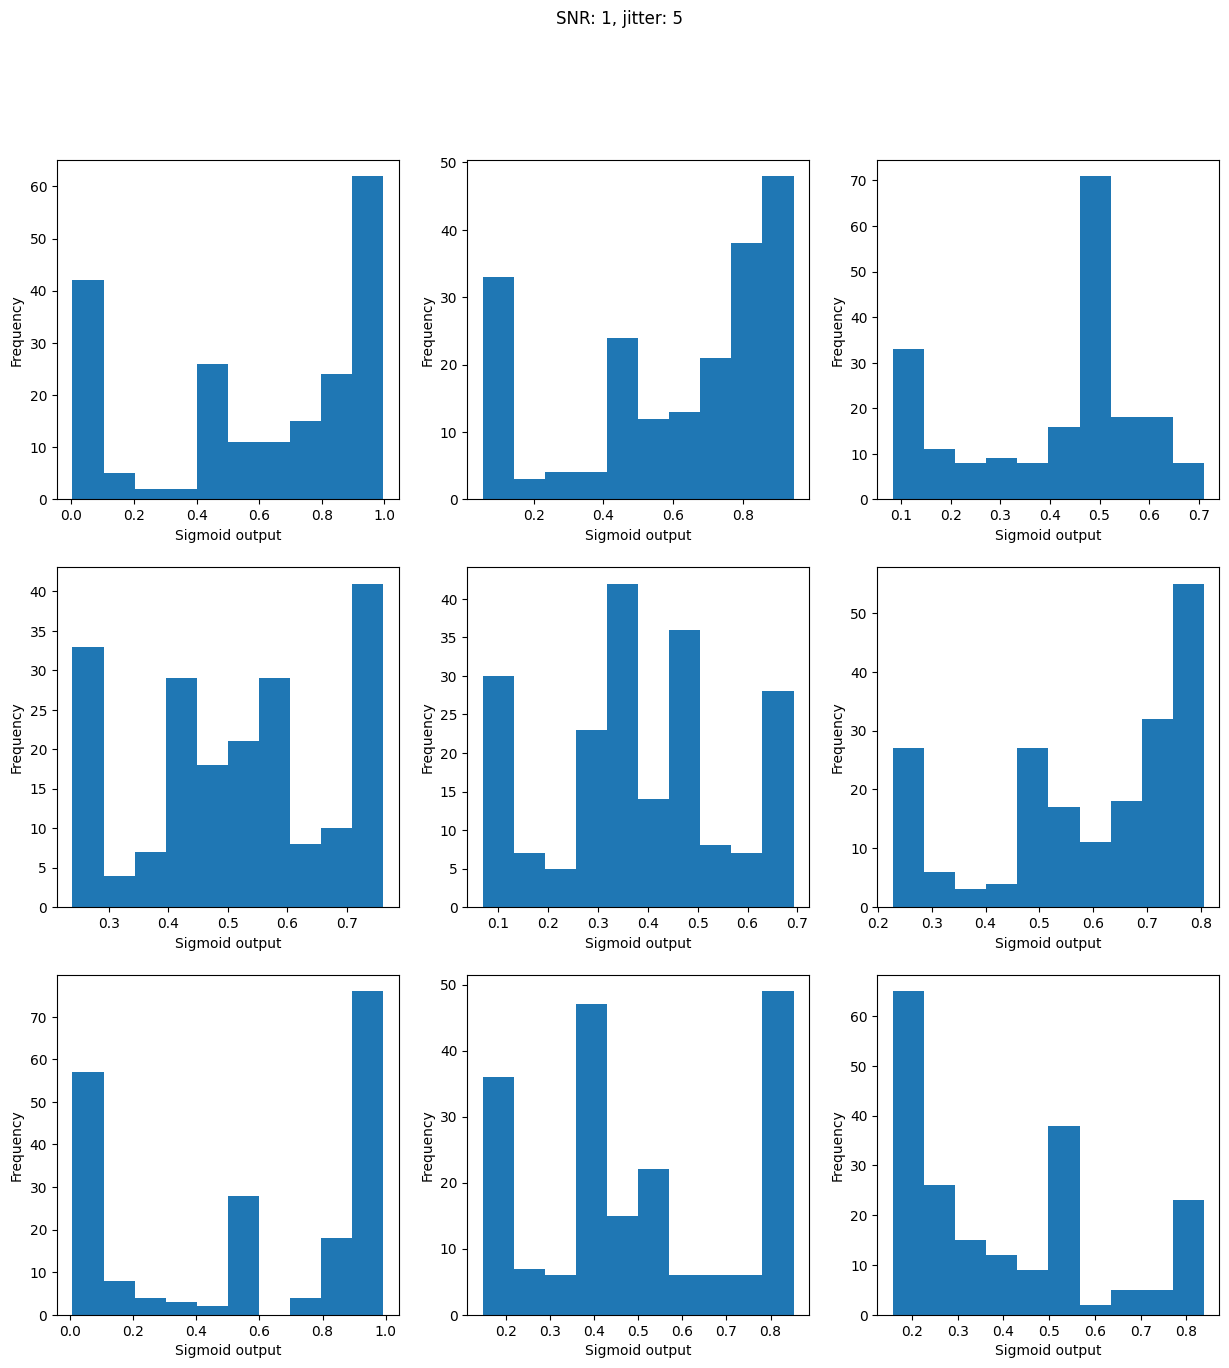

In [113]:
sig_trials_, _ = histograms(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, jitter_val = 5, snr = 1, trials = 9)

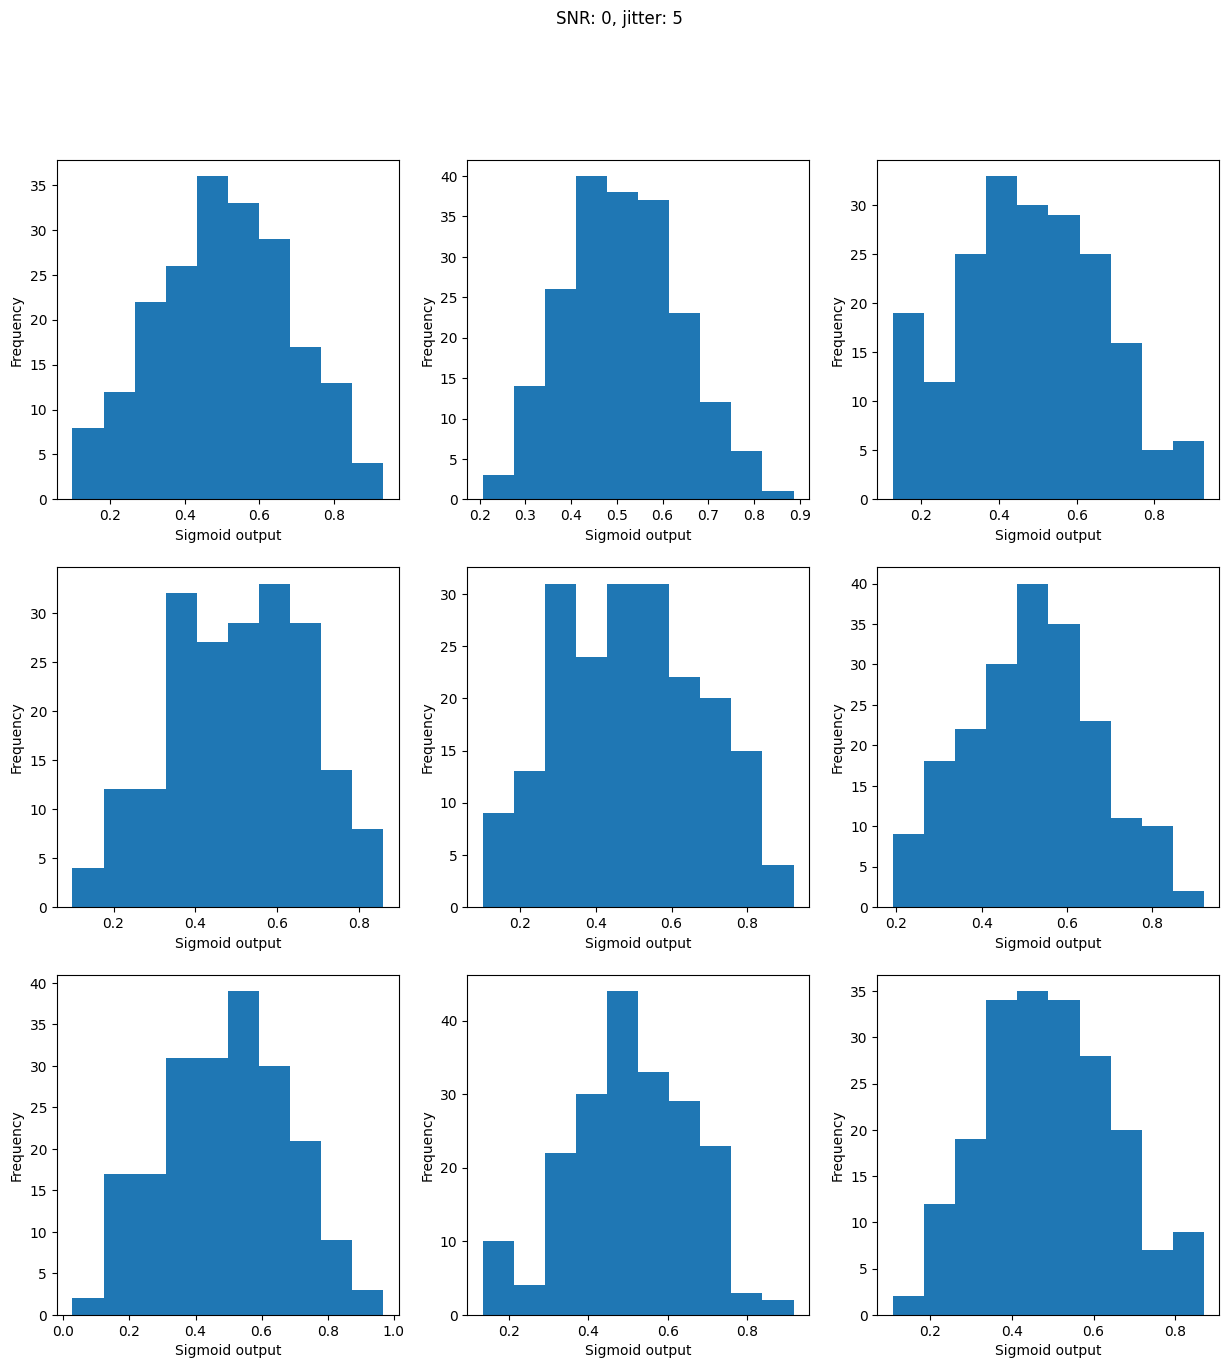

In [114]:
sig_trials_, _ = histograms(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, jitter_val = 5, snr = 0, trials = 9)

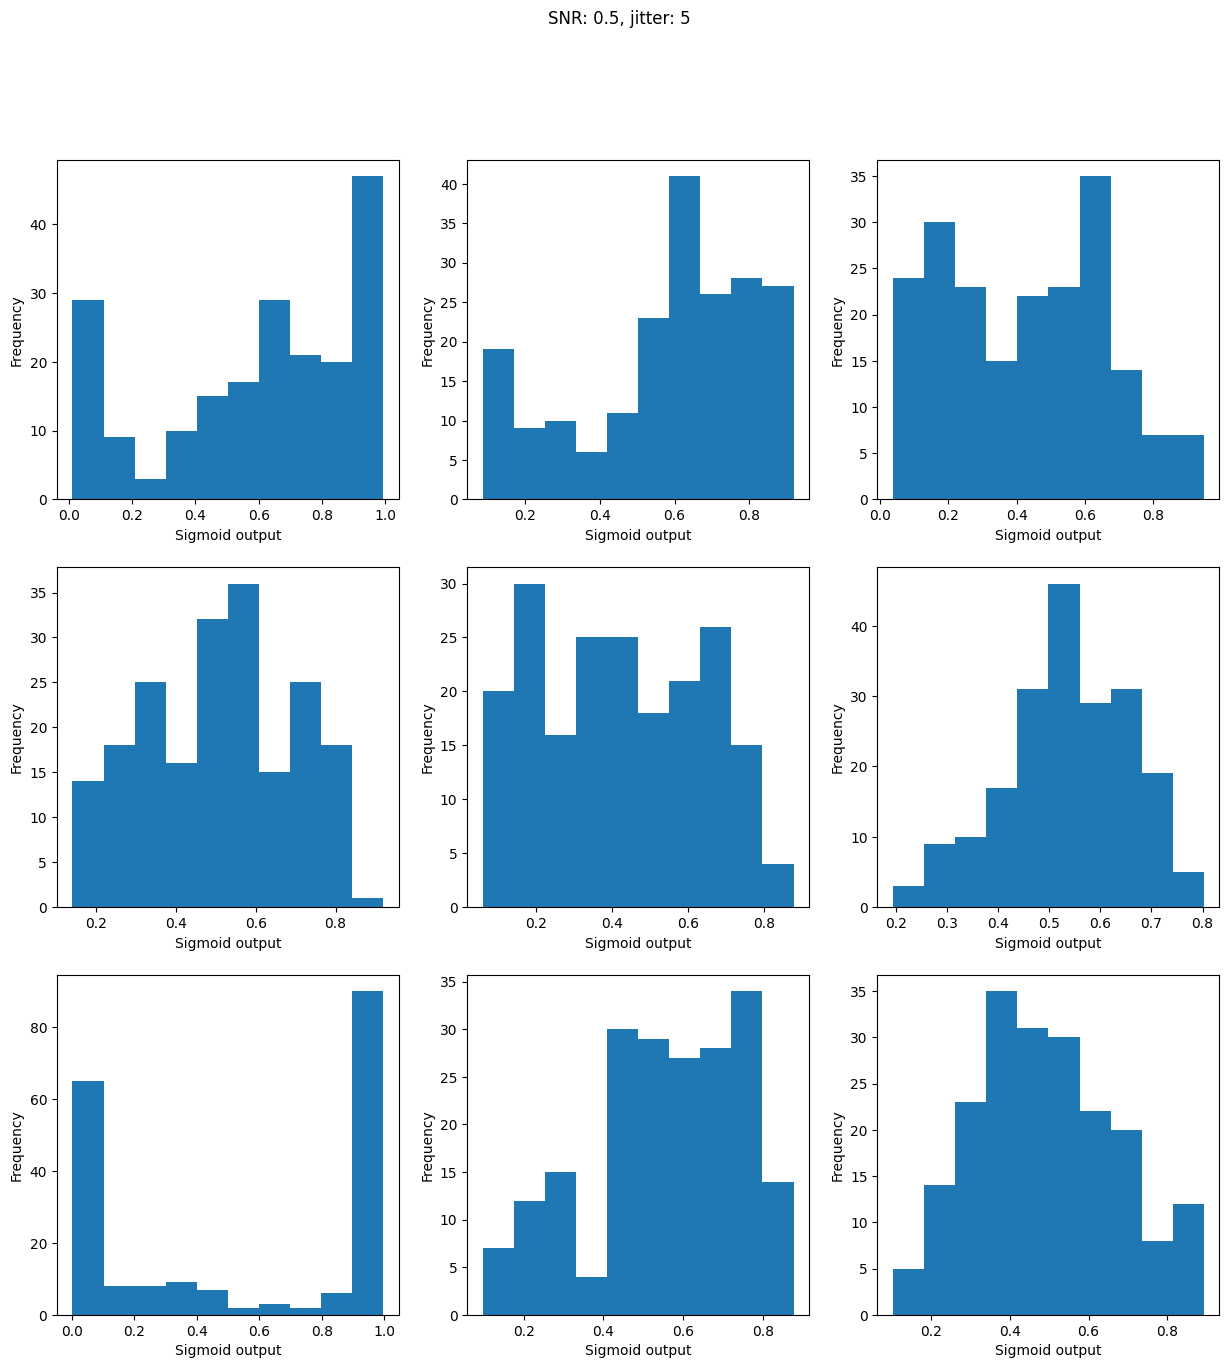

In [115]:
sig_trials_, _ = histograms(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, jitter_val = 5, snr = 0.5, trials = 9)

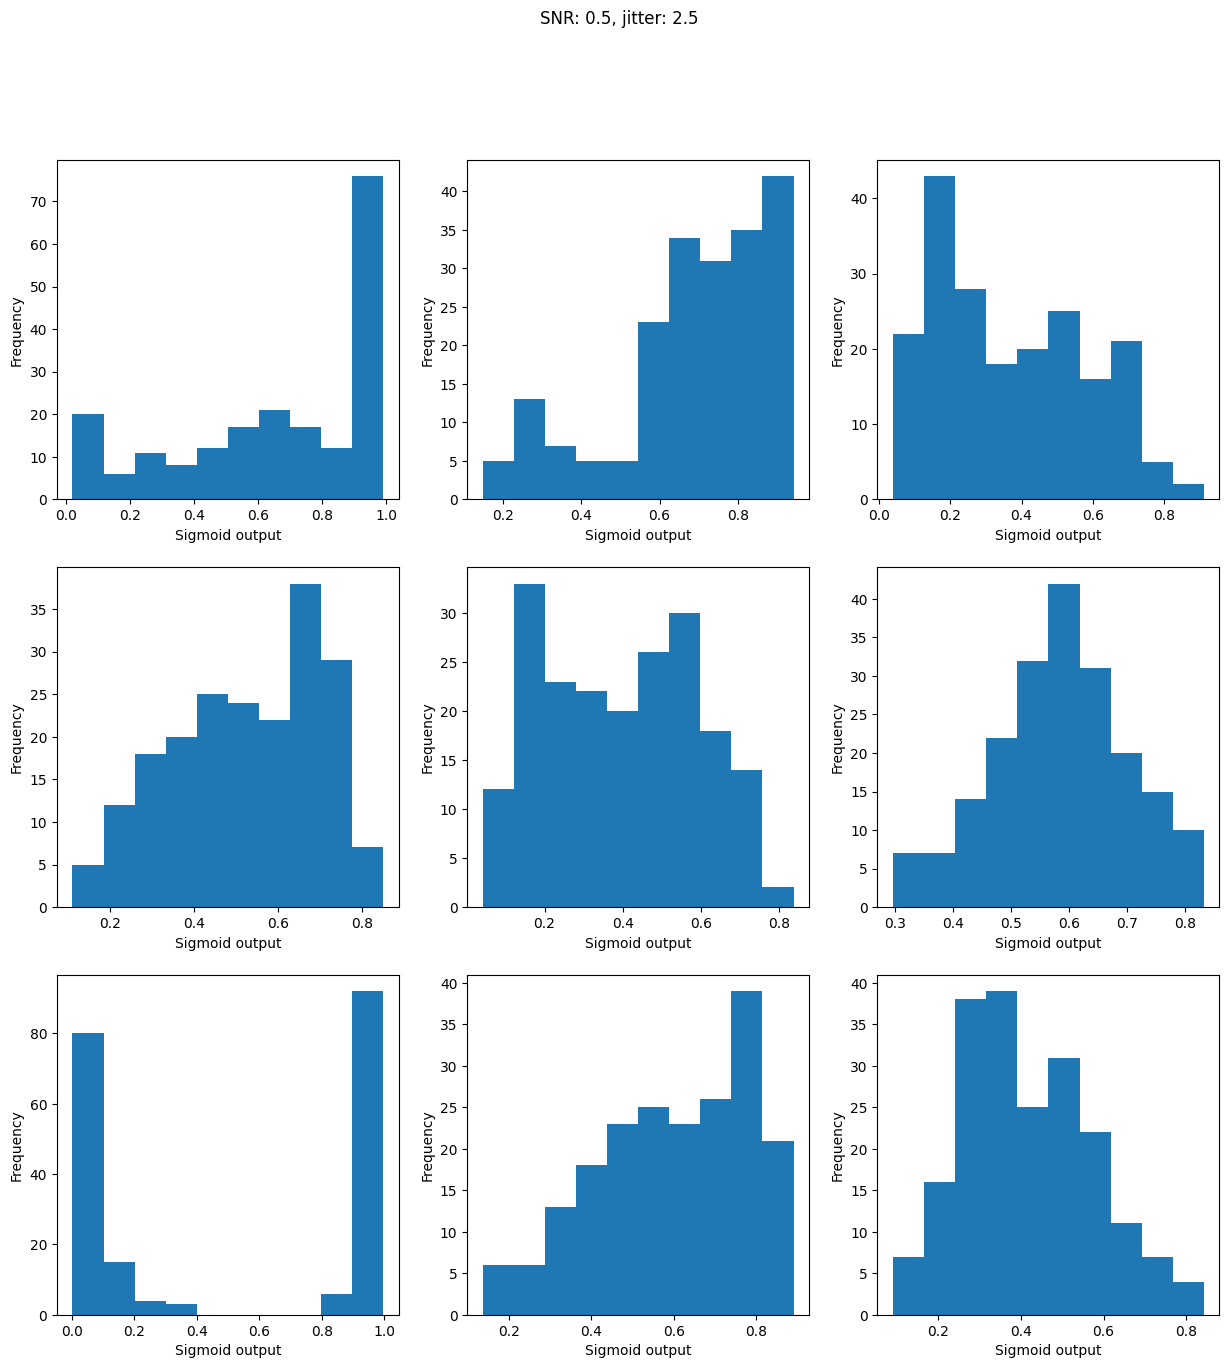

In [124]:
sig_trials_, _ = histograms(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, jitter_val = 2.5, snr = 0.5, trials = 9)